In [32]:
import time
import random
import numpy as np
import pandas as pd

import multiprocessing
from multiprocessing import Pool

import matplotlib.pyplot as plt
from itertools import combinations

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.datasets import load_digits

In [50]:
#importing a built in sklearn function to create a simulated dataset
from sklearn.datasets.samples_generator import make_blobs
# generate 5d classification dataset
X, y = make_blobs(n_samples=6000, centers=5, n_features=10)

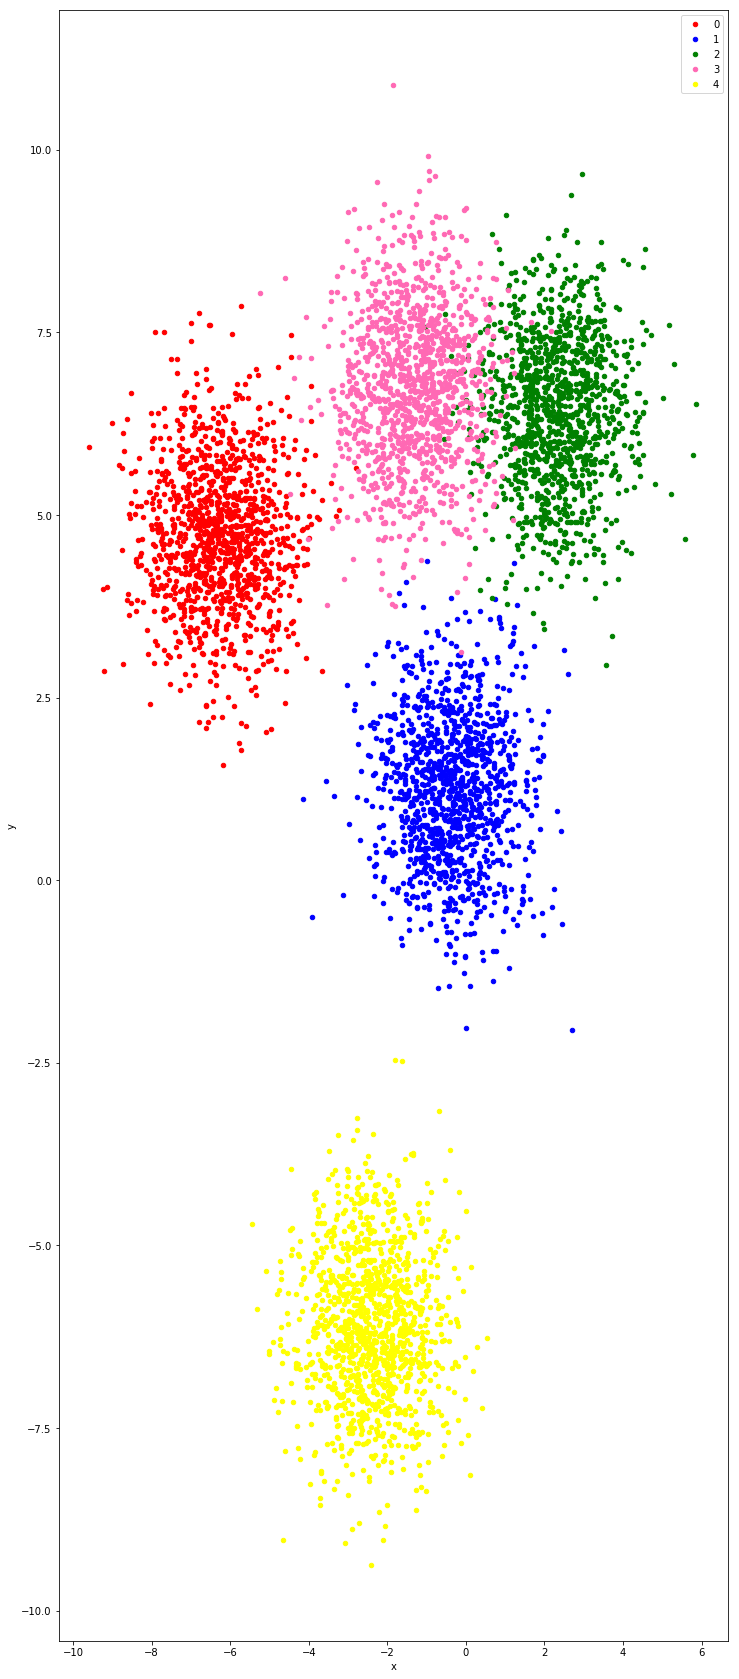

In [51]:
# a plot showing how data is distributed, colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'hotpink', 4:'yellow', 5:'chocolate',
          6:'slateblue', 7:'orangered', 8:'plum', 9:'lawngreen'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [52]:
#splitting the data into train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

scaler = StandardScaler()
#standardizing the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
#writing functions to return the requisite data, required for multiprocessing

def get_x_train():
    return X_train

def get_y_train():
    return y_train

def get_y_test():
    return y_test

def get_x_test():
    return X_test

In [54]:
#defining loss function for objective

def obj_loss_fun_output(beta, x_i, y_i, h=0.5):
    prod = y_i*(np.dot(x_i,beta))
    if prod > 1+h:
        return 0
    elif abs(1-prod) <= h:
        out = ((1+h-prod)**2)/(4*h)
        return out
    elif prod < 1-h:
        return (1-prod)

## writing objective function

def computeobj(beta, X=X_train, y=y_train, l=0.1):
    n,d = X.shape
    obj1 = np.zeros(n)
    for i in range(n):
        obj1[i] = obj_loss_fun_output(beta,X[i],y[i])
    part_1 = (1/n)*np.sum(obj1)
    part_2 = l*(((np.linalg.norm(beta, ord=2)))**2)
    return np.array(part_1+part_2)

In [55]:
#defining loss function for gradient

def grad_loss_fun_output(beta, x_i, y_i, h=0.5):
    prod1 = y_i*(np.dot(x_i,beta))
    if prod1 > 1+h:
        return 0
    elif abs(1-prod1) <= h:
        out2 = (1+h-prod1)/(-2*h)
        return out2
    elif prod1 < 1-h:
        return -1
    
def computegrad(beta, X=X_train, y=y_train, l=0.1):
    n,d = X.shape
    obj1 = np.zeros(n)
    for i in range(n):
        obj1[i] = grad_loss_fun_output(beta,X[i],y[i])
    first_part = (1/n)*np.dot(X.T,y*obj1)
    second_part = 2*l*beta
    return np.array(first_part+second_part)

In [56]:
## backtracking function iterates through and returns optimal eta value, we also set a max_iter
## limit to prevent it from running too long
def backtracking(current_eta,t,current_beta,X=X_train, y=y_train,l=0.1,alpha=0.5,gamma=0.8):
    max_iter = 200
    iter_num = 0
    eta = current_eta
    grad_curr = computegrad(current_beta,X,y,l)
    norm_grad_curr = np.linalg.norm(grad_curr)
    while computeobj(current_beta-eta*grad_curr,X,y) > (computeobj(current_beta,X,y) - alpha*eta*(norm_grad_curr**2)) and iter_num < max_iter:
#         print("iter_backtrack:{}, eta:{}".format(iter_num,eta))
        eta = gamma*eta
        iter_num = iter_num+1
    return eta

In [57]:
## mylinearsvm uses the X_train and y_train matrices and calculates the optimal beta values.
## it reurns a list of beta_vals which is a collection of beta values calculated
## at each iteration. Each iteration returns beta values with a lower objective than
## the previous one. The goal is to get the ideal beta_vals which have the lowest 
## objective possible
def mylinearsvm(X=X_train,y=y_train,eta=1,max_iter=250,eps=0.0001,l=0.1):

    n,d = X.shape
    
    beta_t = np.zeros(d)
    theta_t = np.zeros(d)
    
    beta_vals = [beta_t]
    
    del_beta_t = computegrad(beta_t,X,y,l)
    
    grad_norm = eps
    
    iter_num = 0
    
    eta_current = eta
    
    while iter_num < max_iter and grad_norm >= eps:
#         print("iter: {}, norm:{}".format(iter_num, grad_norm))
        eta_current = backtracking(eta_current,iter_num,beta_t,X,y,l) #get eta with backtracking
        beta_t_1 = theta_t - eta_current*computegrad(theta_t,X,y,l) #beta_t+1
        theta_t_1 = beta_t_1 + (iter_num/(iter_num+3))*(beta_t_1 - beta_t) #theta_t+1
        beta_t = beta_t_1
        theta_t = theta_t_1
        beta_vals.append(beta_t)
        grad_norm = (np.linalg.norm(beta_t, ord=2))**2
        iter_num = iter_num + 1

    return np.array(beta_vals)

In [58]:
# This is the one_vs_one master function which for each combination of classes returns the optimal
## beta values. We use this to decide the number of counts for each feature with respect to every class
## The most frequent class is decided as its label
def onevone(this_tuple):
    
    print('predicting for tuple ',this_tuple)
    num1 = this_tuple[0]
    num2 = this_tuple[1]
    
    y_train = get_y_train()
    X_train = get_x_train()

    idx_train = ((y_train == num1) ^ (y_train == num2))

    subset_train_x = X_train[idx_train]
    subset_train_y = y_train[idx_train]

    subset_train_y = [-1 if yi==num1 else 1 for yi in subset_train_y]

    out_vals_this_tuple = mylinearsvm(X=subset_train_x, y=subset_train_y,l=1)

    return np.array(out_vals_this_tuple)

In [59]:
### Instead of iterating through each combination iteratively, we are using multiprocessing to iterate 
## over as many combinations as possible at once.
if __name__ == '__main__':
    pool = Pool()
    comb_list = list(combinations(range(len(np.unique(y_train))), 2))
    results1 = pool.map(onevone, comb_list)
    pool.close()

predicting for tuple  (1, 3)
predicting for tuple  (0, 3)
predicting for tuple  (2, 3)
predicting for tuple  (2, 4)
predicting for tuple  (1, 2)
predicting for tuple  (0, 1)
predicting for tuple  (1, 4)
predicting for tuple  (0, 4)
predicting for tuple  (3, 4)
predicting for tuple  (0, 2)


In [60]:
## Storing the x,y sub matrices for each combination
y_vals = {}
x_vals = {}
for i in comb_list:
    num1 = i[0]
    num2 = i[1]
    tup1 = (num1,num2)
    X_train = get_x_train()
    y_train = get_y_train()
    idx_train = ((y_train == num1) ^ (y_train == num2))
    subset_train_x = X_train[idx_train]
    subset_train_y = y_train[idx_train]
    subset_train_y = [-1 if yi==num1 else 1 for yi in subset_train_y]
    x_vals[tup1] = subset_train_x
    y_vals[tup1] = subset_train_y

In [61]:
## calcluating the objective for each combination
objective_vals = {}
for i in comb_list:
    j = 0
    num1 = i[0]
    num2 = i[1]
    tup1 = (num1,num2)
    obj_val = [computeobj(beta, x_vals[tup1], y_vals[tup1]) for beta in results1[j]]
    objective_vals[tup1] = obj_val
    j = j + 1

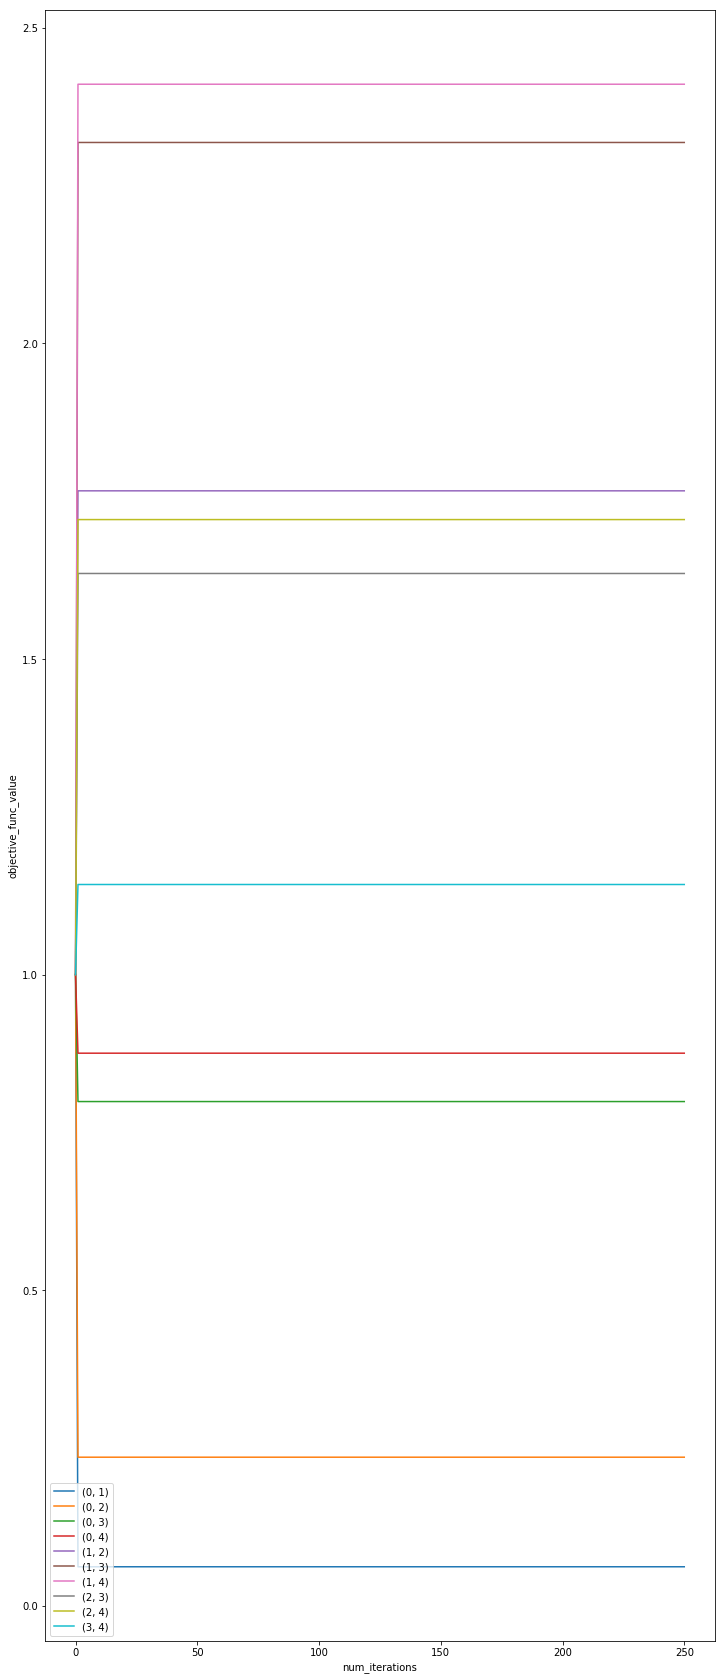

In [62]:
## plotting the objectives
plt.rcParams["figure.figsize"] = (12,30)

for combntn in comb_list:
    plt.plot(range(len(objective_vals[combntn])), objective_vals[combntn], label= combntn)
plt.xlabel('num_iterations')
plt.ylabel('objective_func_value')
plt.legend()

We see above that the objective values for some pairs are increasing while it's decreasing for others.

In [63]:
beta_vals_dict = {}
j = 0
for i in comb_list:
    tup1 = (i[0],i[1])
    beta_vals_dict[tup1] = results1[j][-1]
    j = j + 1

In [64]:
## the predict_class defines hhow frequently is a feature being marked as belonging to
## a class. The most frequent class is returned as the final prediction.
def predict_class(input_feature):
    
    predict_dict = {}
    for i in range(len(np.unique(y_train))):
        predict_dict.setdefault(i,0)
    
    for i in comb_list:
        num1 = i[0]
        num2 = i[1]
        tup1 = (num1,num2)
        
        this_beta = beta_vals_dict[(tup1)]
        pred_val = np.dot(input_feature,this_beta)
        
        if pred_val >= 0:
            predict_dict[num2] += 1
        else:
            predict_dict[num1] += 1
        
        max_val = max(predict_dict.values())
        xout = [k for k,v in predict_dict.items() if v == max_val]
        
    return random.choice(xout)

In [65]:
n1, d1 = X_test.shape
multiclass_predict_test = np.zeros(n1)
for i in range(n1):
    multiclass_predict_test[i] = predict_class(X_test[i])

n2, d2 = X_train.shape
multiclass_predict_train = np.zeros(n2)
for i in range(n2):
    multiclass_predict_train[i] = predict_class(X_train[i])

In [66]:
## calculating the train and test mse errors
mse_val_train = 1-accuracy_score(y_train, multiclass_predict_train)
print("The train misclassification error is: {}".format(mse_val_train))

mse_val_test = 1-accuracy_score(y_test, multiclass_predict_test)
print("The test misclassification error is: {}".format(mse_val_test))

The train misclassification error is: 0.0
The test misclassification error is: 0.0


Dues to the size of data perhaps, we are seeing a perfect prediction with no error.